In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json
from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
import subprocess
import dask
from dask.distributed import Client
import timeit

from esio import metrics
from esio import ice_plot

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

In [2]:
c = Client()
c

Client Scheduler: tcp://127.0.0.1:35987 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 67.47 GB


In [3]:
E = ed.EsioData.load()

In [4]:
# Load file
ds = xr.open_mfdataset(E.obs['NSIDC_0051']['sipn_nc']+'_yearly/*.nc', concat_dim='time', 
                       autoclose=True, parallel=True, chunks={'time':365})

In [5]:
print("Found times ",ds.time.values[0],"through",ds.time.values[-1])
ds.reset_coords(names='hole_mask',drop='True',inplace='True')  # get rid of hole_mask
ds=ds.drop('extent') # get rid of as much stuff as possible
ds=ds.drop('area')

Found times  1979-01-02T00:00:00.000000000 through 2018-12-31T00:00:00.000000000


In [6]:
# Define start and end years
ystart = '1980'
yend = '2010'
ds = ds.sel(time=slice(ystart, yend))
print(ds)

<xarray.Dataset>
Dimensions:  (time: 9888, x: 304, y: 448)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
  * time     (time) datetime64[ns] 1980-01-01 1980-01-03 ... 2010-12-31
Data variables:
    sic      (time, y, x) float64 dask.array<shape=(9888, 448, 304), chunksize=(183, 448, 304)>


In [7]:
# Call function to get mean sip
ds_sip = metrics.calc_hist_sip(ds_sic=ds.sic, ystart=ystart, yend=yend, sic_threshold=0.15, fill_pole_hole=False)

<xarray.DataArray 'sic' (time: 9888, y: 448, x: 304)>
dask.array<shape=(9888, 448, 304), dtype=float64, chunksize=(183, 448, 304)>
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
  * time     (time) datetime64[ns] 1980-01-01 1980-01-03 ... 2010-12-31


In [8]:
ds_sip.load();

In [9]:
# Save
ds_sip.name = 'sip'
ds_sip.to_netcdf(os.path.join(E.obs_dir,'NSIDC_0051','agg_nc','hist_SIP_'+ystart+'_'+yend+'.nc'))

In [14]:
# Load in and test
ds_sip = xr.open_dataset(os.path.join(E.obs_dir,'NSIDC_0051','agg_nc','hist_SIP_'+ystart+'_'+yend+'.nc'))

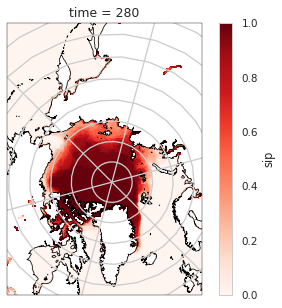

In [16]:
# Test plot
(f, axes) = ice_plot.polar_axis()
ds_sip.sip.sel(time=280).plot.pcolormesh(cmap='Reds',ax=axes, x='lon', y='lat',transform=ccrs.PlateCarree())

In [12]:
ds_sip=None

In [17]:
# convert time in ds to DOY                                                                                                                
DOY = [x.timetuple().tm_yday for x in pd.to_datetime(ds.time.values)]
ds['time'] = DOY
# Calculate mean SIC                                                                                                     
mean_sic = ds.groupby('time').mean(dim='time')
mean_sic.load();
# Save
mean_sic.to_netcdf(os.path.join(E.obs_dir,'NSIDC_0051','agg_nc','mean_'+ystart+'_'+yend+'sic.nc'))

In [20]:
mean_sic = xr.open_dataset(os.path.join(E.obs_dir,'NSIDC_0051','agg_nc','mean_'+ystart+'_'+yend+'sic.nc'))

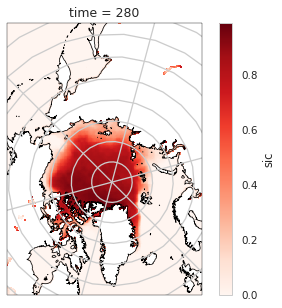

In [21]:
# Test plot
(f, axes) = ice_plot.polar_axis()
mean_sic.sic.sel(time=280).plot.pcolormesh(cmap='Reds',ax=axes, x='lon', y='lat',transform=ccrs.PlateCarree())